In [1]:
# FIRST STEP
# interact with the operating system 
import os
from pathlib import Path
import git
import glob
import csv
import h5py
# data structuration and calculations
import pandas as pd  # to create data frames
import numpy as np   # most important numerical calculations
import pingouin as pg
from scipy import signal
from scipy.spatial import distance
from scipy import stats
from itertools import combinations
# importing torch to test stuff written by Peter
import torch
# read in mat files
import readmat
# needed to extract the run number out of the parentesis of the string in the SPM.mat file
import re
# optimize time performance
import time
# plotting
import matplotlib.pyplot as plt

/gpfs01/bartels/user/vplikat/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
################################################
# VARIABLES FOR PATH SELECTION AND DATA ACCESS #
################################################
HOME            = str(Path.home())
# DATA
PROJ_DIR        = os.path.join(HOME, 'Documents/Magic_fMRI/DATA/MRI')
RAW_DIR         = os.path.join(PROJ_DIR, 'rawdata')
DERIVATIVES_DIR = os.path.join(PROJ_DIR, 'derivatives')
DATA_DIR = os.path.join(DERIVATIVES_DIR, 'decoding', 'decoding_magic')

In [6]:
# define ROIs
ROIS = [
        'V1', 'V2', 'V3', 'hV4',  # Benson
        'V3A', 'V3B', 'LO', 'VO', 'IPS',  # Benson
        'PH',  # Glasser 12d,13d (inferior temporal gyrus, temporo-occipital division LR)
        'IPC',  # Glasser 4d (anterior supramarginal gyrus L)
        'IFJ', #'44', 
        '6r',  # Glasser d15, d16 (inferior frontal gyrus LR)
        'BA6', 'FEF',  # Glasser 9d, 10d, 1p (superior/middle frontal gyrus LR)
        'pACC', 'mACC', 'aACC', '8BM',  # Glasser 5d,6d,4p (ACC LR)
        'AI', 'AVI',  # Glasser 7d,8d (anterior insula LR)
        'IFS', #'45', 'BA46',  # Glasser 3d, 3p (inferior frontal gyrus, pars triangularis L)
        'A8', #'BA9'  # Glasser 2p (middle frontal gyrus/DLPFC L)
      ]

In [4]:
################
# ROI decoding #
################
basenames = ['decode_effect', 'decode_magic_vs_nomagic']
num_labels = [3,2]
all_magic = 'all_videos'
pre_revelation = 'pre_videos'
post_revelation = 'post_videos'

data = [pre_revelation, post_revelation, all_magic]

over_objects = 'over_objects'
over_tricks = 'over_tricks'

over_what = [over_objects, over_tricks]

In [5]:
for base in basenames:
    for runs in data:
        for over in over_what:
            path = os.path.join(DATA_DIR, base, runs,
                               over, 'SpecialMoment',
                               'ROI-analysis','group-statistics')
            results = pd.read_csv(os.path.join(path,'max-statistic-results.csv'))
            results.to_excel('./'+base+'_'+runs+'_'+over+'.xlsx')

-----------------------------------------------------
comparing decode_effect over_objects pre vs post
-----------------------------------------------------
Result of paired ttest on V1: t=2.8992322572910503(p=0.004043075559863255)
Result of paired ttest on V2: t=3.169215620398651(p=0.0021409864530612804)
Result of paired ttest on V3: t=0.8764314343284716(p=0.19492889861669527)
Result of paired ttest on hV4: t=0.8375187121619522(p=0.2054599254565379)
Result of paired ttest on V3A: t=0.1565193824167845(p=0.43849470907593535)
Result of paired ttest on V3B: t=0.8776872610615145(p=0.19459495536429822)
Result of paired ttest on LO: t=2.3437154813108902(p=0.014051048689175496)
Result of paired ttest on VO: t=1.1654155927653398(p=0.12789764136397427)
Result of paired ttest on IPS: t=2.619738250657625(p=0.0076584693825464)
Result of paired ttest on PH: t=3.1345243209212157(p=0.0023252652543150694)
Result of paired ttest on IPC: t=1.6862540782415463(p=0.05263333013647803)
Result of paired ttest

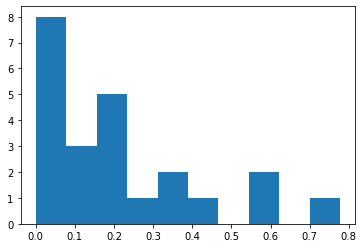

In [7]:
basenames = ['decode_effect']
over_what = [over_objects]
for base in basenames:
    for over in over_what:
        print('-----------------------------------------------------')
        print('comparing ' + base +' '+ over + ' pre vs post')
        print('-----------------------------------------------------')
        ps = []
        path_pre = os.path.join(DATA_DIR, base, pre_revelation,
                           over, 'SpecialMoment',
                           'ROI-analysis','group-statistics')
        path_post = os.path.join(DATA_DIR, base, post_revelation,
                                   over, 'SpecialMoment',
                                   'ROI-analysis','group-statistics')
        res_pre = pd.read_csv(os.path.join(path_pre,'accuracies.csv'))
        res_post = pd.read_csv(os.path.join(path_post,'accuracies.csv'))
        for roi in ROIS:
            ttest_res = pg.ttest(x=res_pre[roi],y=res_post[roi],paired=True,alternative='greater')
            print('Result of paired ttest on {}: t={}(p={})'.format(roi,
                                                                ttest_res['T'].values[0], 
                                                                ttest_res['p-val'].values[0]))
            ps.append(ttest_res['p-val'].values[0])
        fig = plt.figure()
        plt.hist(ps);



--------------------------------------------------
T-test accuracy in ventricle against chance:decode_effect over_objects pre_videos
--------------------------------------------------
t=1.959239824435787(p=0.031157554701296553)
mean accuracy = 0.3587962962962963


--------------------------------------------------
T-test accuracy in ventricle against chance:decode_effect over_tricks pre_videos
--------------------------------------------------
t=-0.25943509165072176(p=0.60119619746551)
mean accuracy = 0.3304398148148148


--------------------------------------------------
T-test accuracy in ventricle against chance:decode_effect over_objects post_videos
--------------------------------------------------
t=1.1927616745901704(p=0.12256144880663165)
mean accuracy = 0.34722222222222227


--------------------------------------------------
T-test accuracy in ventricle against chance:decode_effect over_tricks post_videos
--------------------------------------------------
t=1.357139125107455

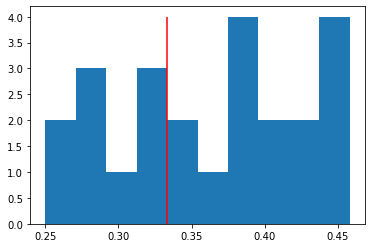

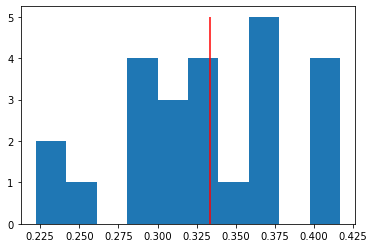

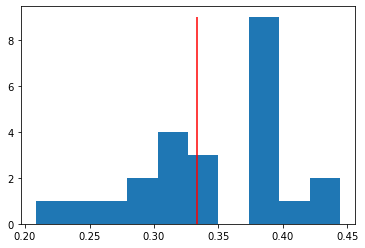

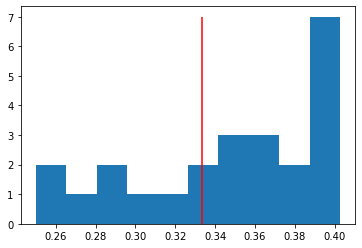

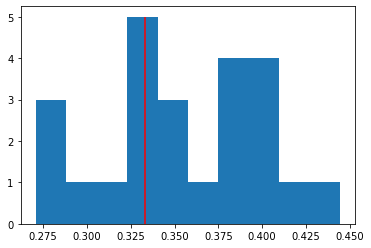

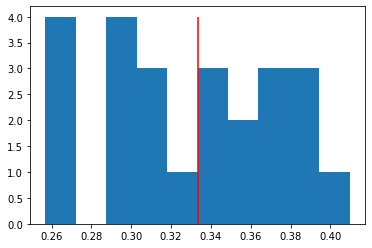

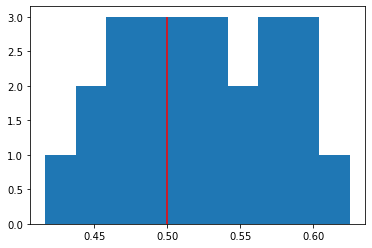

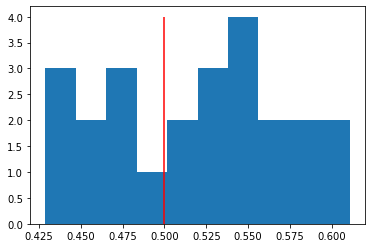

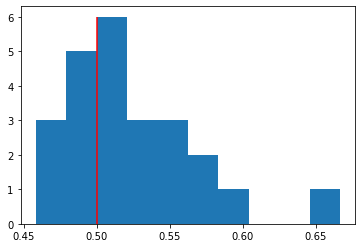

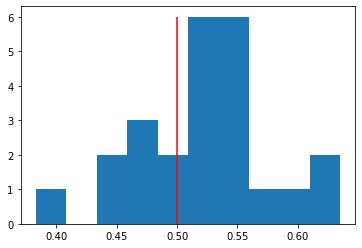

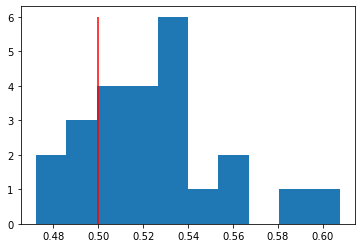

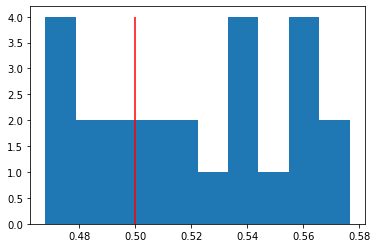

In [60]:
ps_dict = {
    'what':[],
    'over':[],
    'data':[],
    'p-vals':[]
}

for base, labels in zip(basenames,num_labels):
    for runs in data:
        for over in over_what:
            
            print('\n')
            print('--------------------------------------------------')
            print('T-test accuracy in ventricle against chance:' + base +' '+ over + ' ' + runs)
            print('--------------------------------------------------')
            path = os.path.join(DATA_DIR, base, runs,
                               over, 'SpecialMoment',
                               'ROI-analysis')
            subjects = glob.glob(os.path.join(path,'sub-*'))
            subjects.sort()
            accuracies = []
            for sub in subjects:
                ventricle = os.path.join(sub,'3rd-ventricle.hdf5')
                res = h5py.File(ventricle,'r')
                accuracies.append(res['accuracy'][()])
            norm = pg.normality(accuracies)
            ttest_res = pg.ttest(x=accuracies,y=1/labels,alternative='greater')
            
            ps_dict['what'].append(base)
            ps_dict['over'].append(over)
            ps_dict['data'].append(runs)
            ps_dict['p-vals'].append(ttest_res['p-val'].values[0])
            
            if not norm.normal.values:
                print('Normality not given')
            print('t={}(p={})'.format(ttest_res['T'].values[0], 
                                      ttest_res['p-val'].values[0]))
            print('mean accuracy = {}'.format(np.mean(accuracies)))
            fig = plt.figure()
            hist = plt.hist(accuracies)
            plt.vlines(x=(1/labels),ymin=0,ymax=max(hist[0]),color='red')

In [61]:
ps_df = pd.DataFrame(data=ps_dict,columns=ps_dict.keys())
ps_df

,what,over,data,p-vals
0,decode_effect,over_objects,pre_videos,0.031158
1,decode_effect,over_tricks,pre_videos,0.601196
2,decode_effect,over_objects,post_videos,0.122561
3,decode_effect,over_tricks,post_videos,0.093953
4,decode_effect,over_objects,all_videos,0.029069
5,decode_effect,over_tricks,all_videos,0.680023
6,decode_magic_vs_nomagic,over_objects,pre_videos,0.030653
7,decode_magic_vs_nomagic,over_tricks,pre_videos,0.051928
8,decode_magic_vs_nomagic,over_objects,post_videos,0.024430
9,decode_magic_vs_nomagic,over_tricks,post_videos,0.035163


In [75]:
for base, labels in zip(basenames,num_labels):
    for runs in data:
        for over in over_what:
            path = os.path.join(DATA_DIR, base, runs,
                               over, 'SpecialMoment',
                               'ROI-analysis')
            subjects = glob.glob(os.path.join(path,'sub-*'))
            subjects.sort()
            accuracies = []
            null_distributions = []
            for sub in subjects:
                ventricle = os.path.join(sub,'3rd-ventricle.hdf5')
                res = h5py.File(ventricle,'r')
                accuracies.append(res['accuracy'][()])
                null_distributions.append(res['null_distribution'][()])

            mean_accuracy = np.mean(accuracies)
            mean_null_distribution = np.mean(null_distributions,axis=0)
            
            p = sum(mean_null_distribution>mean_accuracy)
            p = (p+1)/(mean_null_distribution.shape[0]+1)
            print(base+' '+runs+' '+over)
            print(mean_accuracy)
            print(p)
            #print(np.argsort(accuracies))

decode_effect pre_videos over_objects
0.3587962962962963
0.022977022977022976
decode_effect pre_videos over_tricks
0.3304398148148148
0.5844155844155844
decode_effect post_videos over_objects
0.34722222222222227
0.15084915084915085
decode_effect post_videos over_tricks
0.3460648148148148
0.16283716283716285
decode_effect all_videos over_objects
0.35271990740740744
0.015984015984015984
decode_effect all_videos over_tricks
0.3289930555555556
0.6673326673326674
decode_magic_vs_nomagic pre_videos over_objects
0.521701388888889
0.014985014985014986
decode_magic_vs_nomagic pre_videos over_tricks
0.5191822066822067
0.03396603396603397
decode_magic_vs_nomagic post_videos over_objects
0.5199652777777778
0.027972027972027972
decode_magic_vs_nomagic post_videos over_tricks
0.5214403651903652
0.017982017982017984
decode_magic_vs_nomagic all_videos over_objects
0.5238715277777778
0.000999000999000999
decode_magic_vs_nomagic all_videos over_tricks
0.5211004273504273
0.003996003996003996


In [103]:
base = 'decode_magic_vs_nomagic'
runs = 'pre_videos'
over = 'over_objects'
path = os.path.join(DATA_DIR, base, runs,
                   over, 'SpecialMoment',
                   'ROI-analysis')
subjects = glob.glob(os.path.join(path,'sub-*'))
subjects.sort()
accuracies = []
null_distributions = []
for sub in subjects:
    ventricle = os.path.join(sub,'L_A1_ROI.hdf5')
    res = h5py.File(ventricle,'r')
    accuracies.append(res['accuracy'][()])
    null_distributions.append(res['null_distribution'][()])

mean_accuracy = np.mean(accuracies)
mean_null_distribution = np.mean(null_distributions,axis=0)

p = sum(mean_null_distribution>mean_accuracy)
p = (p+1)/(mean_null_distribution.shape[0]+1)
print(base+' '+runs+' '+over)
print(mean_accuracy)
print(p)
#print(np.argsort(accuracies))

decode_magic_vs_nomagic pre_videos over_objects
0.5159143518518519
0.06493506493506493


In [100]:
res['accuracy'][()]

0.5555555555555555